In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

from bikesharing.ml_logic.model import get_folds, train_test_indices
from bikesharing.interface.main import *
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_X = pd.read_csv('~/.lewagon/bikesharing/data/processed/X_processed_from_2019_to_2022.csv')
df_y = pd.read_csv('~/.lewagon/bikesharing/data/processed/y_processed_from_2019_to_2022.csv')

In [3]:
df_X

,temperature_2m,relativehumidity_2m,apparent_temperature,windspeed_10m,precipitation,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,is_holiday,is_weekend
0,0.355408,1.000000,0.342007,0.227848,0.017391,0.629410,0.982963,0.75,0.933013,0.600779,0.989739,1,0
1,0.357616,0.987013,0.340149,0.245570,0.008696,0.750000,0.933013,0.75,0.933013,0.600779,0.989739,1,0
2,0.359823,1.000000,0.336431,0.303797,0.017391,0.853553,0.853553,0.75,0.933013,0.600779,0.989739,1,0
3,0.359823,0.987013,0.332714,0.341772,0.008696,0.933013,0.750000,0.75,0.933013,0.600779,0.989739,1,0
4,0.359823,1.000000,0.332714,0.356962,0.000000,0.982963,0.629410,0.75,0.933013,0.600779,0.989739,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,0.426049,0.779221,0.405204,0.202532,0.000000,0.066987,0.750000,0.50,1.000000,0.500000,1.000000,0,1
35036,0.412804,0.779221,0.395911,0.172152,0.000000,0.146447,0.853553,0.50,1.000000,0.500000,1.000000,0,1
35037,0.410596,0.753247,0.390335,0.182278,0.000000,0.250000,0.933013,0.50,1.000000,0.500000,1.000000,0,1
35038,0.417219,0.714286,0.390335,0.222785,0.000000,0.370590,0.982963,0.50,1.000000,0.500000,1.000000,0,1


In [4]:
df_X_y = pd.concat((df_X, df_y) , axis=1)

In [5]:
districts = ['Altstadt-Lehel', 'Au - Haidhausen',
       'Aubing-Lochhausen-Langwied', 'Berg am Laim', 'Bogenhausen',
       'Feldmoching', 'Hadern', 'Harlaching', 'Hasenbergl-Lerchenau Ost',
       'Laim', 'Lochhausen', 'Ludwigsvorstadt-Isarvorstadt', 'Maxvorstadt',
       'Milbertshofen-Am Hart', 'Moosach', 'Neuhausen-Nymphenburg',
       'Obergiesing', 'Obermenzing', 'Obersendling', 'Pasing',
       'Pasing-Obermenzing', 'Ramersdorf-Perlach', 'Schwabing-Freimann',
       'Schwabing-West', 'Schwanthalerhöhe', 'Sendling', 'Sendling-Westpark',
       'Südgiesing', 'Thalkirchen', 'Trudering', 'Trudering-Riem',
       'Untergiesing', 'Untergiesing-Harlaching', 'Untermenzing-Allach']

In [6]:
fold_dfs = get_folds(df_X_y, fold_length=FOLD_LENGTH, fold_stride=FOLD_STRIDE)

In [18]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]
        
    for id in range(4):
        xgb_r = XGBRegressor(objective ='reg:linear',
                  n_estimators = 10, seed = 123)

        test_df = fold_dfs[id]
        train_folds = [fold_dfs[i] for i in indices if i != id]
        
        train_df = pd.concat(train_folds, axis=0)
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        

        
        xgb_r.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in xgb_r.predict(X_test)]
        #scores = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_error(y_test, xgb_r.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))

[16:44:38] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0 >>> scores=[5.093993110236394]
[16:44:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
1 >>> scores=[5.093993110236394, 5.306599377661944]
[16:44:40] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
2 >>> scores=[5.093993110236394, 5.306599377661944, 4.315839839369941]
[16:44:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
3 >>> scores=[5.093993110236394, 5.306599377661944, 4.315839839369941, 4.926116458831631]
[16:44:41] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
0 >>> scores=[2.4946190595250846]
[16:44:42] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
1 >>> 

In [19]:
scores_df = pd.DataFrame(district_score_means, columns=['score'], index=districts)

In [20]:
scores_df.sort_values(by=['score'], inplace=True) 

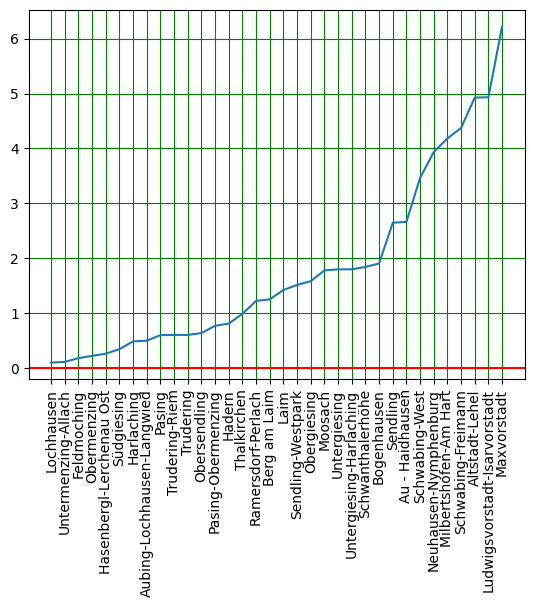

In [21]:
plt.plot(scores_df.index, scores_df['score'])
plt.xticks(rotation=90)
plt.axhline(y=0, color='r', linestyle='-')
plt.grid(c='g')


plt.show()

In [22]:
print(f"mean = {np.mean(district_score_means)}")
print(f"min = {np.min(district_score_means)}")
print(f"max = {np.max(district_score_means)}")

mean = 1.7869088466140113
min = 0.1034126158598734
max = 6.217635437812912


# Maxvorstadt

In [23]:
models = []
district_score_means = []
district = 'Maxvorstadt'

xgb_r = XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)

test_df = fold_dfs[0]
train_folds = fold_dfs[1:]
        
train_df = pd.concat(train_folds, axis=0)
X_test = test_df.drop(columns= districts)
y_test = test_df[district]
X_train = train_df.drop(columns= districts)
y_train = train_df[district]
        

        
xgb_r.fit(X_train, y_train)
y_pred = xgb_r.predict(X_test)
#scores = r2_score(y_test , y_pred)
mse_score = np.sqrt(mean_squared_error(y_test, y_pred))

[17:02:26] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


In [24]:
print(f'MSE: {mse_score}')

MSE: 6.767914905995791


# Train Test Validation

In [ ]:
models = []
district_score_means = []

for dist in districts:
    scores_list = []

    indices = [0, 1, 2, 3]

    for i, item in enumerate(fold_dfs):
        model = XGBRegressor()
        copy_dfs = fold_dfs[:]
        test_df = copy_dfs[i]
        if i <= 2:
            val_df = copy_dfs[i+1]
        else:
            val_df = copy_dfs[0]
        copy_dfs.remove(test_df)
        copy_dfs.remove(val_df)
        train_folds = copy_dfs
        train_df = pd.concat(train_folds, axis=0)
        
        X_test = test_df.drop(columns= districts)
        y_test = test_df[dist]
        X_val = val_df.drop(columns= districts)
        y_val = val_df[dist]
        X_train = train_df.drop(columns= districts)
        y_train = train_df[dist]
        
        
        model.fit(X_train, y_train)
        y_pred = [x if x >= 0 else 0 for x in model.predict(X_test)]
        # scores = r2_score(y_test , y_pred)
        scores = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        scores_list.append(scores)
        print(f"{id} >>> scores={scores_list}")
        
        
    scores_array = np.array(scores)
    district_score_means.append(np.mean(scores_array.flatten()))